In [1]:
%%capture --no-display

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance

# spectrome imports
from spectrome.brain import Brain
from spectrome.utils import functions, path
from spectrome.forward import eigenmode, get_complex_laplacian

In [2]:
def get_meanC(Call):
    #C = np.mean(Call, axis = 2)
    C = (Call + np.transpose(Call))/2
    ss = np.sort(C[:])[::-1]
    C = np.minimum(C,ss[np.round(0.01*len(ss)).astype('int')])
    return C

## Subject Specific analysis starts here, we will first compute the eigen decompositions and then binarize the 39 subject's eigen modes:

In [3]:
# Load 39 subject DK86 atlas:
# to read the h5 file:
hf = h5py.File('/home/axiezai/lab/spectral/data/spectrome/CDK86_individual.h5', 'r')

# to see what's in the dataset, call keys:
hf.keys()

# grab the dataset with the get method:
cdk86_individual = hf.get('CDK86_individual')

# convert the returned h5 object to numpy array:
cdk86_individual = np.array(cdk86_individual)
hf.close()

##### House Keeping #####
n_subjs = cdk86_individual.shape[2]
nrois = cdk86_individual.shape[0]

# Define frequency range of interest
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin,fmax,40)
# get the complex laplacian and its eigen modes:
f2w = np.abs(fvec-10).argmin() #8th index = alpha ~10hz
w = 2*np.pi*fvec[f2w]

# Load Pablo's Yeo 2017 canonical network maps
com_dk = np.load('/home/axiezai/lab/brain-scfc/spectrome/spectrome/data/com_dk.npy').item()
DK_df_normalized = pd.read_csv('/home/axiezai/lab/brain-scfc/spectrome/spectrome/data/DK_dictionary_normalized.csv').set_index('Unnamed: 0')
coords = np.array([com_dk[region] for region in DK_df_normalized.columns])
# Create FC network jupyter widget for visiualization
fc_names = ['Visual','Limbic', 'Default', 'Somatomotor', 'Frontoparietal', 'Ventral_Attention', 'Dorsal_Attention']

In [4]:
hcp_dir = "/home/axiezai/lab/brain-scfc/spectrome/spectrome/data"
brain = Brain.Brain()
brain.add_connectome(hcp_dir)

brain.reorder_connectome(brain.connectome, brain.distance_matrix)
hcp_distance_matrix = get_meanC(brain.distance_matrix)
hcp_connectome = brain.connectome

In [5]:
# From Ashish's old code - to tweak individual connectomes from Julia:
vdcind = np.array([76, 85])
cerind = np.array([68,77])
mult_hcp = np.mean(hcp_connectome[hcp_connectome > 0])
concat_inds = np.concatenate((vdcind, cerind))
q = np.squeeze(hcp_connectome[concat_inds,:])

In [6]:
n_ev = 86 # 25 eigen modes
cdk86_connectomes = np.zeros([nrois,nrois,n_subjs])
cdk86_individual_eigenmodes = np.zeros([nrois,n_ev,n_subjs])

for i in np.arange(0, n_subjs):
    # Grab individual connectome and do some pre-processing:
    # mult_hcp to scale connectome:
    brain.connectome = cdk86_individual[:,:,i]
    mult_indv = np.mean(brain.connectome[brain.connectome > 0])
    brain.connectome[concat_inds,:] = (mult_indv/mult_hcp)*q
    brain.connectome[:,concat_inds] = np.transpose((mult_indv/mult_hcp)*q)
    #brain.connectome = get_meanC(brain.connectome)
    brain.distance_matrix = hcp_distance_matrix
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    # Get complex laplacian and eigenmodes:
    brain.add_laplacian_eigenmodes(brain.reducedConnectome, brain.distance_matrix, w=w, speed = 10, num_ev = n_ev)
    cdk86_individual_eigenmodes[:,:,i] = brain.norm_eigenmodes
    cdk86_connectomes[:,:,i] = brain.connectome
    brain = Brain.Brain()

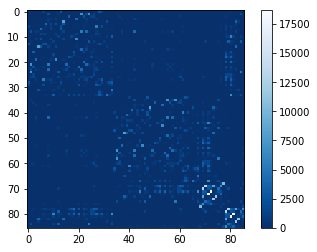

In [7]:
brain.connectome = cdk86_individual[:,:,0]
mult_indv = np.mean(brain.connectome[brain.connectome > 0])
#brain.connectome = get_meanC(brain.connectome)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

plt.imshow(brain.connectome, cmap = plt.cm.Blues_r)
plt.colorbar()

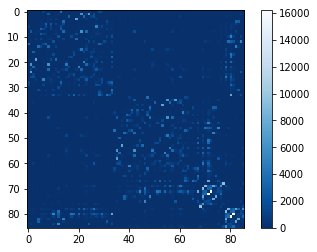

In [8]:
#visualize actual SC
plt.imshow(cdk86_connectomes[:,:,1], cmap = plt.cm.Blues_r)
plt.colorbar()

### Now we have each subject's 86x86 eigenmodes of the complex laplacian, we binarize them and make 86x86 probability map, but first binaize the canonical networks first:

In [9]:
DK_df_normalized

,ctx-lh-bankssts,ctx-lh-caudalanteriorcingulate,ctx-lh-caudalmiddlefrontal,ctx-lh-cuneus,ctx-lh-entorhinal,ctx-lh-fusiform,ctx-lh-inferiorparietal,ctx-lh-inferiortemporal,ctx-lh-isthmuscingulate,ctx-lh-lateraloccipital,...,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Default,0.609756,0.072298,0.517443,0.00201,0.002988,0.002238,0.531757,0.153381,0.820943,0.000865,...,NaN,0.0,NaN,NaN,0.000000,NaN,0.184615,0.0,0.0,NaN
Dorsal_Attention,0.000000,0.000000,0.147862,0.00000,0.000000,0.139721,0.165546,0.314169,0.000000,0.040678,...,NaN,0.0,NaN,NaN,0.000000,NaN,0.000000,0.0,0.0,NaN
Frontoparietal,0.000000,0.324982,0.334696,0.00000,0.000000,0.000000,0.184687,0.187768,0.069145,0.000000,...,NaN,0.0,NaN,NaN,0.000000,NaN,0.000000,0.0,0.0,NaN
Limbic,0.000000,0.000000,0.000000,0.00000,0.997012,0.376033,0.000000,0.323887,0.000000,0.000000,...,NaN,0.0,NaN,NaN,0.140625,NaN,0.269231,1.0,1.0,NaN
Somatomotor,0.251307,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,0.0,NaN,NaN,0.062500,NaN,0.000000,0.0,0.0,NaN
Ventral_Attention,0.138937,0.602720,0.000000,0.00000,0.000000,0.000000,0.000158,0.000000,0.000000,0.000000,...,NaN,0.0,NaN,NaN,0.796875,NaN,0.000000,0.0,0.0,NaN
Visual,0.000000,0.000000,0.000000,0.99799,0.000000,0.482008,0.117852,0.020795,0.109912,0.958457,...,NaN,1.0,NaN,NaN,0.000000,NaN,0.546154,0.0,0.0,NaN


In [15]:
# binarize according to threshold:
threshold, ub, lb = 0.4, 1, 0
# cdk86_binarized_individual_eigenmodes = np.where(cdk86_individual_eigenmodes > 0, ub, lb)
# binarize pandas dataframe?

In [16]:
DKfc_binarized = pd.DataFrame([], index=DK_df_normalized.index, columns=DK_df_normalized.columns)
for name in DK_df_normalized.index:
    DKfc_binarized.loc[name]=np.where(DK_df_normalized.loc[name].values > threshold, ub, lb)
    
DKfc_binarized

,ctx-lh-bankssts,ctx-lh-caudalanteriorcingulate,ctx-lh-caudalmiddlefrontal,ctx-lh-cuneus,ctx-lh-entorhinal,ctx-lh-fusiform,ctx-lh-inferiorparietal,ctx-lh-inferiortemporal,ctx-lh-isthmuscingulate,ctx-lh-lateraloccipital,...,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Default,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Dorsal_Attention,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Frontoparietal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Limbic,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
Somatomotor,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ventral_Attention,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Visual,0,0,0,1,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0


### Now we binarize the eigenmodes:

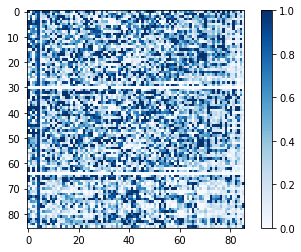

In [17]:
# before binarizing:
plt.imshow(cdk86_individual_eigenmodes[:,:,0], cmap = plt.cm.Blues)
plt.colorbar()

In [18]:
# use the same threshold as canonical networks:
#cdk86_binary_individual_eigenmodes = cdk86_individual_eigenmodes*(cdk86_individual_eigenmodes > threshold)
cdk86_binary_individual_eigenmodes = np.where(cdk86_individual_eigenmodes>threshold, ub, lb)

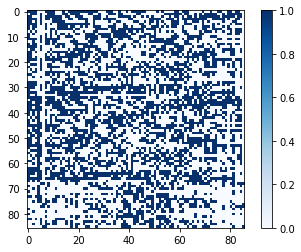

In [19]:
# after binarizing:
plt.imshow(cdk86_binary_individual_eigenmodes[:,:,2], cmap = plt.cm.Blues)
plt.colorbar()

### Use DICE coefficient to measure overlap between eigenmodes and canonical networks:
scipy.spatial.dice(two boolean arrays)

In [22]:
# to do: 1) figure out row or column ordering for eigen modes, index it correctly in this function
def get_dice_df(x,y):
    """[Dice similarity score betewen two boolean arrays, then make it into a Pandas Dataframe
    translate into dataframes after we compute all the arrays?]
    
    Args:
        x ([array]): [eigen mode array with boolean array values]
        y ([Dataframe]): [canonical network data frame with boolean array vaues]

    Returns:
        dice_df [array]: dice scores between each eigen mode and each canonical network    
    """
    df_cols = y.index
    df_ind = ['Eig #%d' % x for x in np.arange(x.shape[1])+1]
    df_dice = pd.DataFrame([], index = df_ind, columns = df_cols)
    eigcounter = 0
    for eignum in df_dice.index:
        for name in y.index:
            em = x[:,eigcounter] #eigen mode values
            fc = y.loc[name].values
            df_dice.at[eignum, name] = distance.dice(em,fc) #*np.count_nonzero(fc) #< - multiply by support?
        eigcounter += 1
    return df_dice

In [23]:
df_dice = get_dice_df(cdk86_binary_individual_eigenmodes[:,:,3],DKfc_binarized)
df_dice.head(10).style.set_caption('Eigenmode Dice Coef').apply(functions.highlight_min, axis=1)

Unnamed: 0,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
Eig #1,0.705882,1,0.821429,0.69697,0.868852,0.8,0.727273
Eig #2,0.6875,1,0.884615,0.709677,0.859649,0.857143,0.580645
Eig #3,0.660377,1,0.804878,0.686275,0.913043,0.866667,0.764706
Eig #4,0.803279,0.956522,0.836735,0.694915,0.814815,0.735849,0.79661
Eig #5,0.857143,0.95122,0.863636,0.592593,0.755102,0.916667,0.703704
Eig #6,0.642857,0.95122,0.863636,0.703704,0.836735,0.958333,0.62963
Eig #7,0.6,1,0.791667,0.689655,0.849057,0.923077,0.862069
Eig #8,1,1,1,0.909091,1,1,0.636364
Eig #9,0.566667,1,0.791667,0.689655,0.698113,0.961538,0.896552
Eig #10,0.661538,0.92,0.924528,0.777778,0.793103,0.859649,0.587302


### Sorting by entropy:

In [26]:
ind_dice_entropy = eigenmode.get_purity_score(df_dice)
df_ind_dice_entropy = pd.DataFrame(ind_dice_entropy, index = df_dice.index, columns = [('Entropy')])
order_index = df_ind_dice_entropy.sort_values(by = 'Entropy', ascending = True).index
ordered_ind_dice = df_dice.reindex(order_index)
ordered_ind_entropy = df_ind_dice_entropy.reindex(order_index)
df_sorted_ind_dice = ordered_ind_dice.join(ordered_ind_entropy)
df_sorted_ind_dice.head(25).style.set_caption('eigenmode dice sorted by purity').apply(functions.highlight_min, subset = ordered_ind_dice.columns, axis = 1)

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual,Entropy
Eig #76,0.647059,1,1,0.795918,0.772727,0.906977,0.510204,1.92292
Eig #27,0.615385,1,0.9,0.56,0.911111,0.954545,0.72,1.9251
Eig #72,0.563636,1,0.813953,0.698113,0.916667,0.914894,0.660377,1.92833
Eig #84,0.925926,1,1,0.68,1,1,0.6,1.92863
Eig #9,0.566667,1,0.791667,0.689655,0.698113,0.961538,0.896552,1.92864
Eig #31,0.6,1,0.875,0.724138,0.660377,1,0.758621,1.92903
Eig #59,0.740741,1,0.952381,0.615385,0.914894,0.956522,0.653846,1.92981
Eig #25,0.6875,0.959184,0.923077,0.580645,0.824561,0.964286,0.709677,1.93055
Eig #14,0.622642,1,0.902439,0.764706,0.913043,0.866667,0.607843,1.93067
Eig #71,0.586207,1,0.826087,0.642857,0.882353,0.92,0.857143,1.93101


## Looking at overlap z scores with individual connectome

In [35]:
df_ind_overlap, df_sxy = eigenmode.get_overlap_score_dfs(cdk86_binary_individual_eigenmodes[:,:,3], DKfc_binarized, threshold = threshold)
ind_olentropy = eigenmode.get_purity_score(df_sxy)

In [38]:
df_sxy.head(10).style.apply(functions.highlight_max, axis =1)

Unnamed: 0,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
Eig #1,0.196078,0,0.0980392,0.196078,0.0784314,0.117647,0.176471
Eig #2,0.212766,0,0.0638298,0.191489,0.0851064,0.0851064,0.276596
Eig #3,0.25,0,0.111111,0.222222,0.0555556,0.0833333,0.166667
Eig #4,0.136364,0.0227273,0.0909091,0.204545,0.113636,0.159091,0.136364
Eig #5,0.102564,0.025641,0.0769231,0.282051,0.153846,0.0512821,0.205128
Eig #6,0.25641,0.025641,0.0769231,0.205128,0.102564,0.025641,0.25641
Eig #7,0.27907,0,0.116279,0.209302,0.0930233,0.0465116,0.0930233
Eig #8,0,0,0,0.142857,0,0,0.571429
Eig #9,0.302326,0,0.116279,0.209302,0.186047,0.0232558,0.0697674
Eig #10,0.229167,0.0416667,0.0416667,0.145833,0.125,0.0833333,0.270833


In [40]:
df_ind_overlap.head(10).style.apply(functions.highlight_max,axis = 1)

Unnamed: 0,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
Eig #1,-0.04297,-1.75312,1.92602,0.680082,-1.37263,0.507517,0.0562721
Eig #2,0.375725,-1.61835,0.237903,0.472827,-0.966417,-0.647243,2.68281
Eig #3,1.02163,-1.18837,1.65883,0.98487,-1.40227,-0.567785,-0.167563
Eig #4,-1.42308,0.0142292,1.32622,0.690184,-0.10787,1.71446,-0.91091
Eig #5,-1.99937,0.135604,0.701825,2.47698,0.918857,-1.52254,0.62337
Eig #6,1.1904,0.115662,0.642465,0.704964,-0.351351,-2.1068,1.7386
Eig #7,1.80374,-1.40599,2.35186,0.808661,-0.697065,-1.76513,-1.98201
Eig #8,-1.3305,-0.446288,-0.684256,-0.224889,-0.965816,-0.928657,2.93233
Eig #9,2.43168,-1.43715,2.3046,0.84659,2.03216,-2.44931,-2.51941
Eig #10,0.788785,1.21509,-0.762799,-0.699997,0.305103,-0.81698,2.62694


In [39]:
df_cols = [('Entropy')]
df_ind = ['Eig #%d' % x for x in np.arange(len(df_sxy.index))+1]
df_olentropy = pd.DataFrame(ind_olentropy, index = df_ind, columns = df_cols)
#df_norm_overlap_z = pd.DataFrame(norm_overlap_score, index = df_ind, columns = df_overlap_score.columns)
#sort by descending purity value
order_index = df_olentropy.sort_values(by = 'Entropy', ascending = True).index
ordered_ind_overlap = df_sxy.reindex(order_index)
ordered_ind_olentropy = df_olentropy.reindex(order_index)
# Combine purity score with overlap score dataframe, and make it look nice
combined_df = ordered_ind_overlap.join(ordered_ind_olentropy)
combined_df.head(25).style.set_caption('Eigen Mode Overlap & Entropy').apply(functions.highlight_max, subset = ordered_ind_overlap.columns, axis = 1)

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual,Entropy
Eig #86,0,0,0,0,0,0,0.5,0
Eig #8,0,0,0,0.142857,0,0,0.571429,0.500402
Eig #85,0.1,0,0,0.3,0,0,0.5,0.936888
Eig #84,0.1,0,0,0.4,0,0,0.5,0.943348
Eig #76,0.264706,0,0,0.147059,0.147059,0.0588235,0.352941,1.46394
Eig #59,0.189189,0,0.027027,0.27027,0.0540541,0.027027,0.243243,1.47425
Eig #37,0.27027,0,0.0540541,0.162162,0.108108,0,0.243243,1.48293
Eig #27,0.285714,0,0.0571429,0.314286,0.0571429,0.0285714,0.2,1.50267
Eig #31,0.27907,0,0.0697674,0.186047,0.209302,0,0.162791,1.5316
Eig #26,0.244444,0,0.0444444,0.2,0.111111,0.0222222,0.222222,1.56887


In [ ]:
# REPRODUCE ASHISH'S PLOT FOR INDIVIDUAL CONNECTOMES

## Histogram of 7 canonical network as function of frequency and transmission speed?

In [38]:
threshold, ub, lb = 0, 1, 0
cdk86_binarized_individual_eigenmodes = np.where(cdk86_individual_eigenmodes > 0, ub, lb)
# find mean along third dimension - 
#individuals_eigen_prob = np.mean(cdk86_individual_eigenmodes, axis = 2)
individual_eigenmodes_prob = np.mean(cdk86_binarized_individual_eigenmodes, axis = 2)

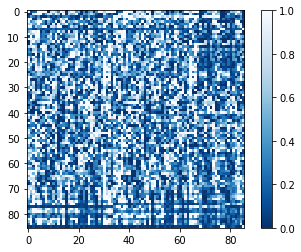

In [43]:
#plt.imshow(individual_eigenmodes_prob, cmap = plt.cm.plasma_r)
plt.imshow(cdk86_individual_eigenmodes[:,:,1], cmap = plt.cm.Blues_r)
plt.colorbar()

### Grab top 25 most pure eigen modes from each subjects structural eigenmode:

In [58]:
# compute overlap and purity scores for all
df_overlap_score, df_sxy = eigenmode.get_overlap_score_dfs(cdk86_individual_eigenmodes[:,:,1], DK_df_normalized)

In [63]:
z_purity, norm_overlap_score = eigenmode.get_purity_score(df_overlap_score)

In [29]:
%%capture --no-display
df_overlap_score, df_sxy = eigenmode.get_overlap_score_dfs(individual_eigenmodes_prob, DK_df_normalized)